## Install deps

In [239]:
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn
# %pip install category_encoders
# %pip install catboost
# %pip install ipywidgets 

## Imports

In [240]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd

# Prepare DataSet for train

## Load dataset

In [241]:
dataframe = read_csv("clear_all_data.csv",sep=';', encoding='utf-8')

## Define args and y

In [242]:
X = dataframe.drop("price_per_m2", axis=1)
y = dataframe.price_per_m2

## Split to train and test dataframes

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

### Encode X train and X test

In [244]:
from category_encoders import CatBoostEncoder

In [245]:
cat_features = ['district', "city"]
encoder = CatBoostEncoder()

In [246]:
X_train_encoded = X_train.copy()
X_train_encoded[cat_features] = encoder.fit_transform(X_train[cat_features], y_train)

In [247]:
X_test_encoded = X_test.copy()
X_test_encoded[cat_features] = encoder.transform(X_test[cat_features])

### Save encoded values + normal names to dicts

In [248]:
city_names_and_encoded_names = pd.DataFrame()

city_names_and_encoded_names["city_name"] = X_test["city"]
city_names_and_encoded_names["city_encoded"] = X_test_encoded["city"]

unique_citys = city_names_and_encoded_names.drop_duplicates()
city_dict = dict(zip(unique_citys["city_name"], unique_citys["city_encoded"]))

In [249]:
district_names_and_encoded_names = pd.DataFrame()

district_names_and_encoded_names["district_name"] = X_test["district"]
district_names_and_encoded_names["district_encoded"] = X_test_encoded["district"]

unique_district = district_names_and_encoded_names.drop_duplicates()
district_dict = dict(zip(unique_district["district_name"], unique_district["district_encoded"]))

### Export dicts to json

In [226]:
import json
import io
import os

In [227]:
with open("city.json", "w") as file:
    json.dump(city_dict, file)

In [228]:
with open("district.json", "w") as file:
    json.dump(district_dict, file)

## Define and train models

In [229]:
model_list = []

In [230]:
param_grid = { "depth" : [3], "learning_rate": [0.375], "iterations": [1550]}

### CatBoost

In [231]:
catboost_regressor = CatBoostRegressor(depth=5, learning_rate=0.1, iterations=5000, loss_function="MAE", od_type="Iter", od_wait=350)
catboost_regressor.fit(X_train_encoded, y_train, eval_set=(X_test_encoded, y_test), plot=True)
model_list.append(catboost_regressor)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 257452.7418816	test: 208097.0688303	best: 208097.0688303 (0)	total: 5.38ms	remaining: 26.9s
1:	learn: 243519.1228605	test: 194468.1829554	best: 194468.1829554 (1)	total: 9.98ms	remaining: 24.9s
2:	learn: 231690.0480282	test: 182758.5729447	best: 182758.5729447 (2)	total: 13.8ms	remaining: 23.1s
3:	learn: 219263.5044614	test: 170447.9970548	best: 170447.9970548 (3)	total: 18.2ms	remaining: 22.8s
4:	learn: 209365.7009809	test: 161284.4080909	best: 161284.4080909 (4)	total: 22.4ms	remaining: 22.4s
5:	learn: 198804.6483416	test: 150226.3103174	best: 150226.3103174 (5)	total: 26.1ms	remaining: 21.7s
6:	learn: 192211.1487730	test: 143672.6412910	best: 143672.6412910 (6)	total: 29.8ms	remaining: 21.3s
7:	learn: 185162.4222866	test: 137059.2210455	best: 137059.2210455 (7)	total: 34.2ms	remaining: 21.3s
8:	learn: 177758.2819761	test: 129760.3261761	best: 129760.3261761 (8)	total: 38.8ms	remaining: 21.5s
9:	learn: 172716.7974654	test: 124970.9014245	best: 124970.9014245 (9)	total: 42.8

# Metrics

## Make prediction

In [232]:
predict_list = []

for model in model_list:
    predict_list.append(model.predict(X_test_encoded))

## Plot of data

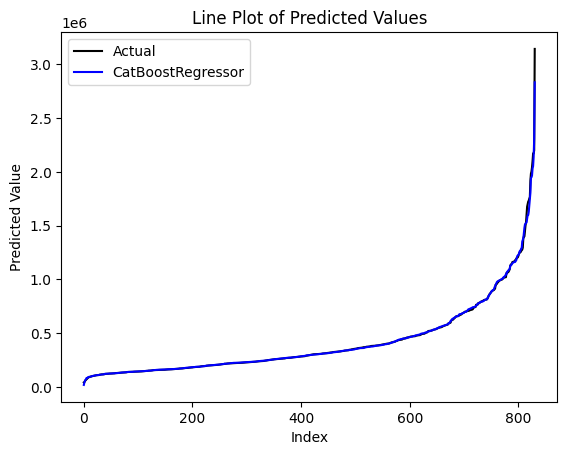

In [233]:
from matplotlib import pyplot as plt
from matplotlib import colors
import pandas as pd
import seaborn as sns
import numpy as np

ALL_COLORS = ["blue","orange","purple","green","white","gray"]

# plt.figure(figsize=(100, 50))
sns.lineplot(x=range(len(y_test)), y=y_test.sort_values(), color='black', label='Actual')
plt.xlabel('Index')
plt.ylabel('Predicted Value')
plt.title('Line Plot of Predicted Values')

for i in range(0, len(model_list)):
    y = np.sort(predict_list[i])
    sns.lineplot(x=range(len(predict_list[i])), y=y, color=ALL_COLORS[i], label=type(model_list[i]).__name__)

plt.show()

## Check score of model

In [234]:
print("Scores: ")
for i, model in enumerate(model_list):
    print(f"\n* {type(model_list[i]).__name__}: {model.score(X_test_encoded, y_test)*100:.2f}%\t")

Scores: 

* CatBoostRegressor: 99.54%	


## Mean errors

In [235]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Absolute

In [236]:
print("MAE (Mean Absolute Error): ")
for i, predict in enumerate(predict_list):
    mse = mean_absolute_error(y_true=y_test, y_pred=predict)
    print(f"\n* {type(model_list[i]).__name__}: {mse:.2f}\t")

MAE (Mean Absolute Error): 

* CatBoostRegressor: 10188.96	


## Save model to file if its good one

In [237]:
import os.path
prediction = catboost_regressor.predict(X_test_encoded)
mas = mean_absolute_error(y_true=y_test, y_pred=prediction)
if mas < 20000:
    i = 0
    filename = f"house_predict-score{catboost_regressor.score(X_test_encoded, y_test):.4f}-mas{mas:.2f}"
    format = "cbm"
    if os.path.isfile(filename + str(i) + "." + format):
        i += 1
    catboost_regressor.save_model(fname=filename + str(i) + "." + format, format="cbm")
else:
    print("bad model")